In [1]:
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_paulivec
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter


In [5]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
gamma=Parameter('gamma')

In [5]:
def schedule_Trotterization(list_T,list_N):
    #T: time step
    #N:trotterization number
    
    gammas=[]
    for i in range(len(list_T)):
        delta_t=list_T[i]/list_N[i]
        
        gammas+=[np.pi * delta_t]
        
        
    return gammas


In [6]:
def N_circuit(depth, gamma, loop):
    
    Ncirc = QuantumCircuit(depth)
    
    #1) bell state to test if my circuit is working or not
    #Ncirc.h(0)
    #Ncirc.cx(0,1)
 
    #initial_state = [0,1]   
    #Ncirc.initialize(initial_state, 0)
    #Ncirc.initialize(initial_state, 1)
    Ncirc.x(1)
    Ncirc.barrier()
    for ii in range(loop): 
            
            
        Ncirc.h(0)
        Ncirc.h(1)
        Ncirc.rzz(gamma,0,1)
    
        Ncirc.barrier()
    
        Ncirc.h(0)
        Ncirc.h(1)
        Ncirc.rzz(gamma,0,1)
        Ncirc.rz(np.pi/4,0)
        Ncirc.rz(np.pi/4,1)
    
        Ncirc.barrier()

        Ncirc.h(0)
        Ncirc.h(1)
        Ncirc.rzz(gamma,0,1)
        Ncirc.h(0)
        Ncirc.h(1)
        Ncirc.rz(-1* np.pi/4,0)
        Ncirc.rz(-1*np.pi/4,1)
            

        
    return Ncirc 
        
        #4) After aplication of this circuit with initialization as X-gate, I get the statevector as '10' even though
        # it is represented as '10' theoretically. 
        
        #5) So, I need to read the measurement inverse order in Qiskit. 
        

In [7]:
import math

In [11]:
print(list_N)

[4, 7, 11, 14, 17, 20, 24, 27, 31, 34, 37, 41, 44, 47, 51, 54, 57, 61, 64, 67, 70, 74, 77, 81, 84, 87, 91, 94, 97]


In [10]:
list_T=[]
list_periods= [i for i in np.arange(0.1,3,0.1)]
for i in range(len(list_periods)):
    list_T+=[list_periods[i]]

max_delta_t=3*10**(-2)
list_N=[]
for j in range(len(list_T)):
    list_N += [math.ceil(list_T[j]/max_delta_t)]

gammas= schedule_Trotterization(list_T,list_N)

In [12]:
A=[]
for k in range(len(list_N)):

    Ncirc = N_circuit(2, gammas[k], list_N[k])
    
    #initialization function:
    #Ncirc.initialize(Statevector.from_label('11').data, range(2))

    Ncirc.measure_all()
    A.append(Ncirc)

In [15]:
circuit = A
#backend = BasicAer.get_backend('qasm_simulator')
real_device = provider.get_backend('ibmq_belem')
job= execute(circuit, backend= real_device, shots= 1024)


result= job.result()
counts= result.get_counts()

print(job.job_id())
job_monitor(job)

61ea7dbe509b0359ecb64a90
Job Status: job has successfully run


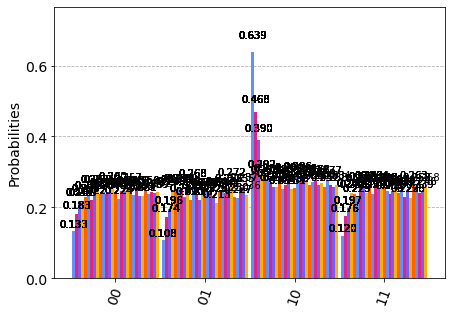

In [16]:
plot_histogram(counts)

In [40]:
print(max(gammas)-min(gammas))

0.01570796326794896


In [41]:
print(counts)

[{'00': 71, '01': 119, '10': 788, '11': 46}, {'00': 73, '01': 430, '10': 442, '11': 79}, {'00': 113, '01': 566, '10': 208, '11': 137}, {'00': 143, '01': 531, '10': 108, '11': 242}, {'00': 199, '01': 338, '10': 232, '11': 255}, {'00': 184, '01': 250, '10': 324, '11': 266}, {'00': 281, '01': 174, '10': 351, '11': 218}, {'00': 298, '01': 196, '10': 334, '11': 196}, {'00': 314, '01': 249, '10': 273, '11': 188}]


In [42]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [43]:
from qiskit.providers.ibmq.managed import *

In [44]:
cal_circuits, state_labels = complete_meas_cal(qr = Ncirc.qregs[0],circlabel ='measerrormitigationcal')

In [60]:
cal_job = execute(cal_circuits,
                 backend = real_device,
                  shots= 1024,
                  optimization_level = 0
                 )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

61e150c4fb13d007bd512bf7
Job Status: job has successfully run


In [63]:
type(result)

qiskit.result.result.Result

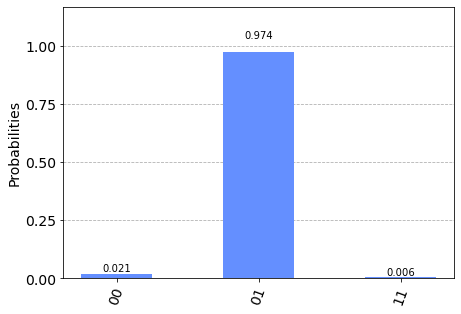

In [64]:
plot_histogram(cal_results.get_counts(cal_circuits[1]))

In [65]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

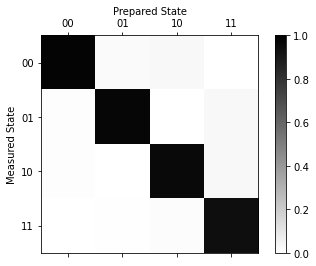

In [66]:
meas_fitter.plot_calibration()

In [67]:
meas_filter = meas_fitter.filter

In [68]:
mitigated_result = meas_filter.apply(result)


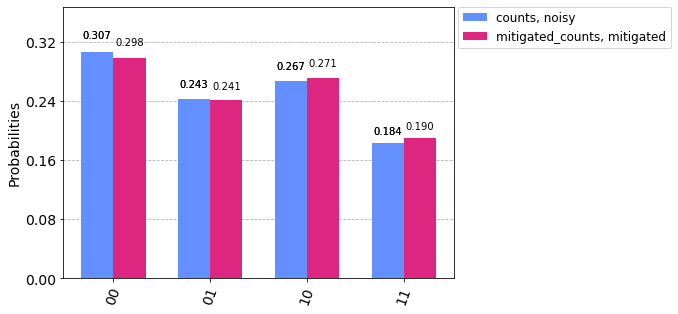

In [69]:
device_counts= result.get_counts(Ncirc)
mitigated_counts = mitigated_result.get_counts(Ncirc)
plot_histogram([device_counts, mitigated_counts], legend=['counts, noisy', 'mitigated_counts, mitigated'])